In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger


In [2]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
batch_size = 8
lr = 1e-4
epochs = 100
height = 336
width = 336

In [4]:
dataset_path = "/Users/kesavreddy/Downloads/College/Sem VII/Computer_Vision/Dataset"
files_dir = "/Users/kesavreddy/Downloads/College/Sem VII/Computer_Vision/Files"
model_file = os.path.join(files_dir, "unet-non-aug.keras")
log_file = os.path.join(files_dir, "log-non-aug.csv")

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Ensure files directory exists
create_dir(files_dir)



In [6]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


In [7]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [8]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

In [9]:
def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model


In [10]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*")))
    train_y = sorted(glob(os.path.join(path, "train", "masks", "*")))

    valid_x = sorted(glob(os.path.join(path, "valid", "images", "*")))
    valid_y = sorted(glob(os.path.join(path, "valid", "masks", "*")))

    return (train_x, train_y), (valid_x, valid_y)


In [11]:
def read_image(path):
    x = cv2.imread(path.decode(), cv2.IMREAD_COLOR)
    x = x / 255.0
    return x

In [12]:
def read_mask(path):
    x = cv2.imread(path.decode(), cv2.IMREAD_GRAYSCALE)
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    return x


In [13]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])

    return x, y



In [14]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [15]:
# Load dataset
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


Train: 2859 - 2859
Valid: 309 - 309


2024-10-31 17:00:49.433344: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-10-31 17:00:49.433368: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-31 17:00:49.433398: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-31 17:00:49.433477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-31 17:00:49.433506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
input_shape = (height, width, 3)
model = build_unet(input_shape)
model.summary()


Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 336, 336, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 336, 336, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 336, 336, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 336, 336, 64)         0         ['batch_normalization[0][0]

In [17]:
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7))
    return iou

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


In [18]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc", iou, precision, recall])


In [19]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [20]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/100


2024-10-31 17:00:57.839843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-10-31 17:00:58.081333: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


358/358 [==============================] - ETA: 0s - loss: 0.1183 - acc: 0.9749 - iou: 0.0536 - precision: 0.7048 - recall: 0.3086
Epoch 1: val_loss improved from inf to 0.07996, saving model to /Users/kesavreddy/Downloads/College/Sem VII/Computer_Vision/Files/unet-non-aug.keras
358/358 [==============================] - 432s 1s/step - loss: 0.1183 - acc: 0.9749 - iou: 0.0536 - precision: 0.7048 - recall: 0.3086 - val_loss: 0.0800 - val_acc: 0.9790 - val_iou: 0.0146 - val_precision: 0.6498 - val_recall: 0.0023 - lr: 1.0000e-04
Epoch 2/100
358/358 [==============================] - ETA: 0s - loss: 0.0514 - acc: 0.9818 - iou: 0.1294 - precision: 0.7760 - recall: 0.5343
Epoch 2: val_loss improved from 0.07996 to 0.04309, saving model to /Users/kesavreddy/Downloads/College/Sem VII/Computer_Vision/Files/unet-non-aug.keras
358/358 [==============================] - 421s 1s/step - loss: 0.0514 - acc: 0.9818 - iou: 0.1294 - precision: 0.7760 - recall: 0.5343 - val_loss: 0.0431 - val_acc: 0.981

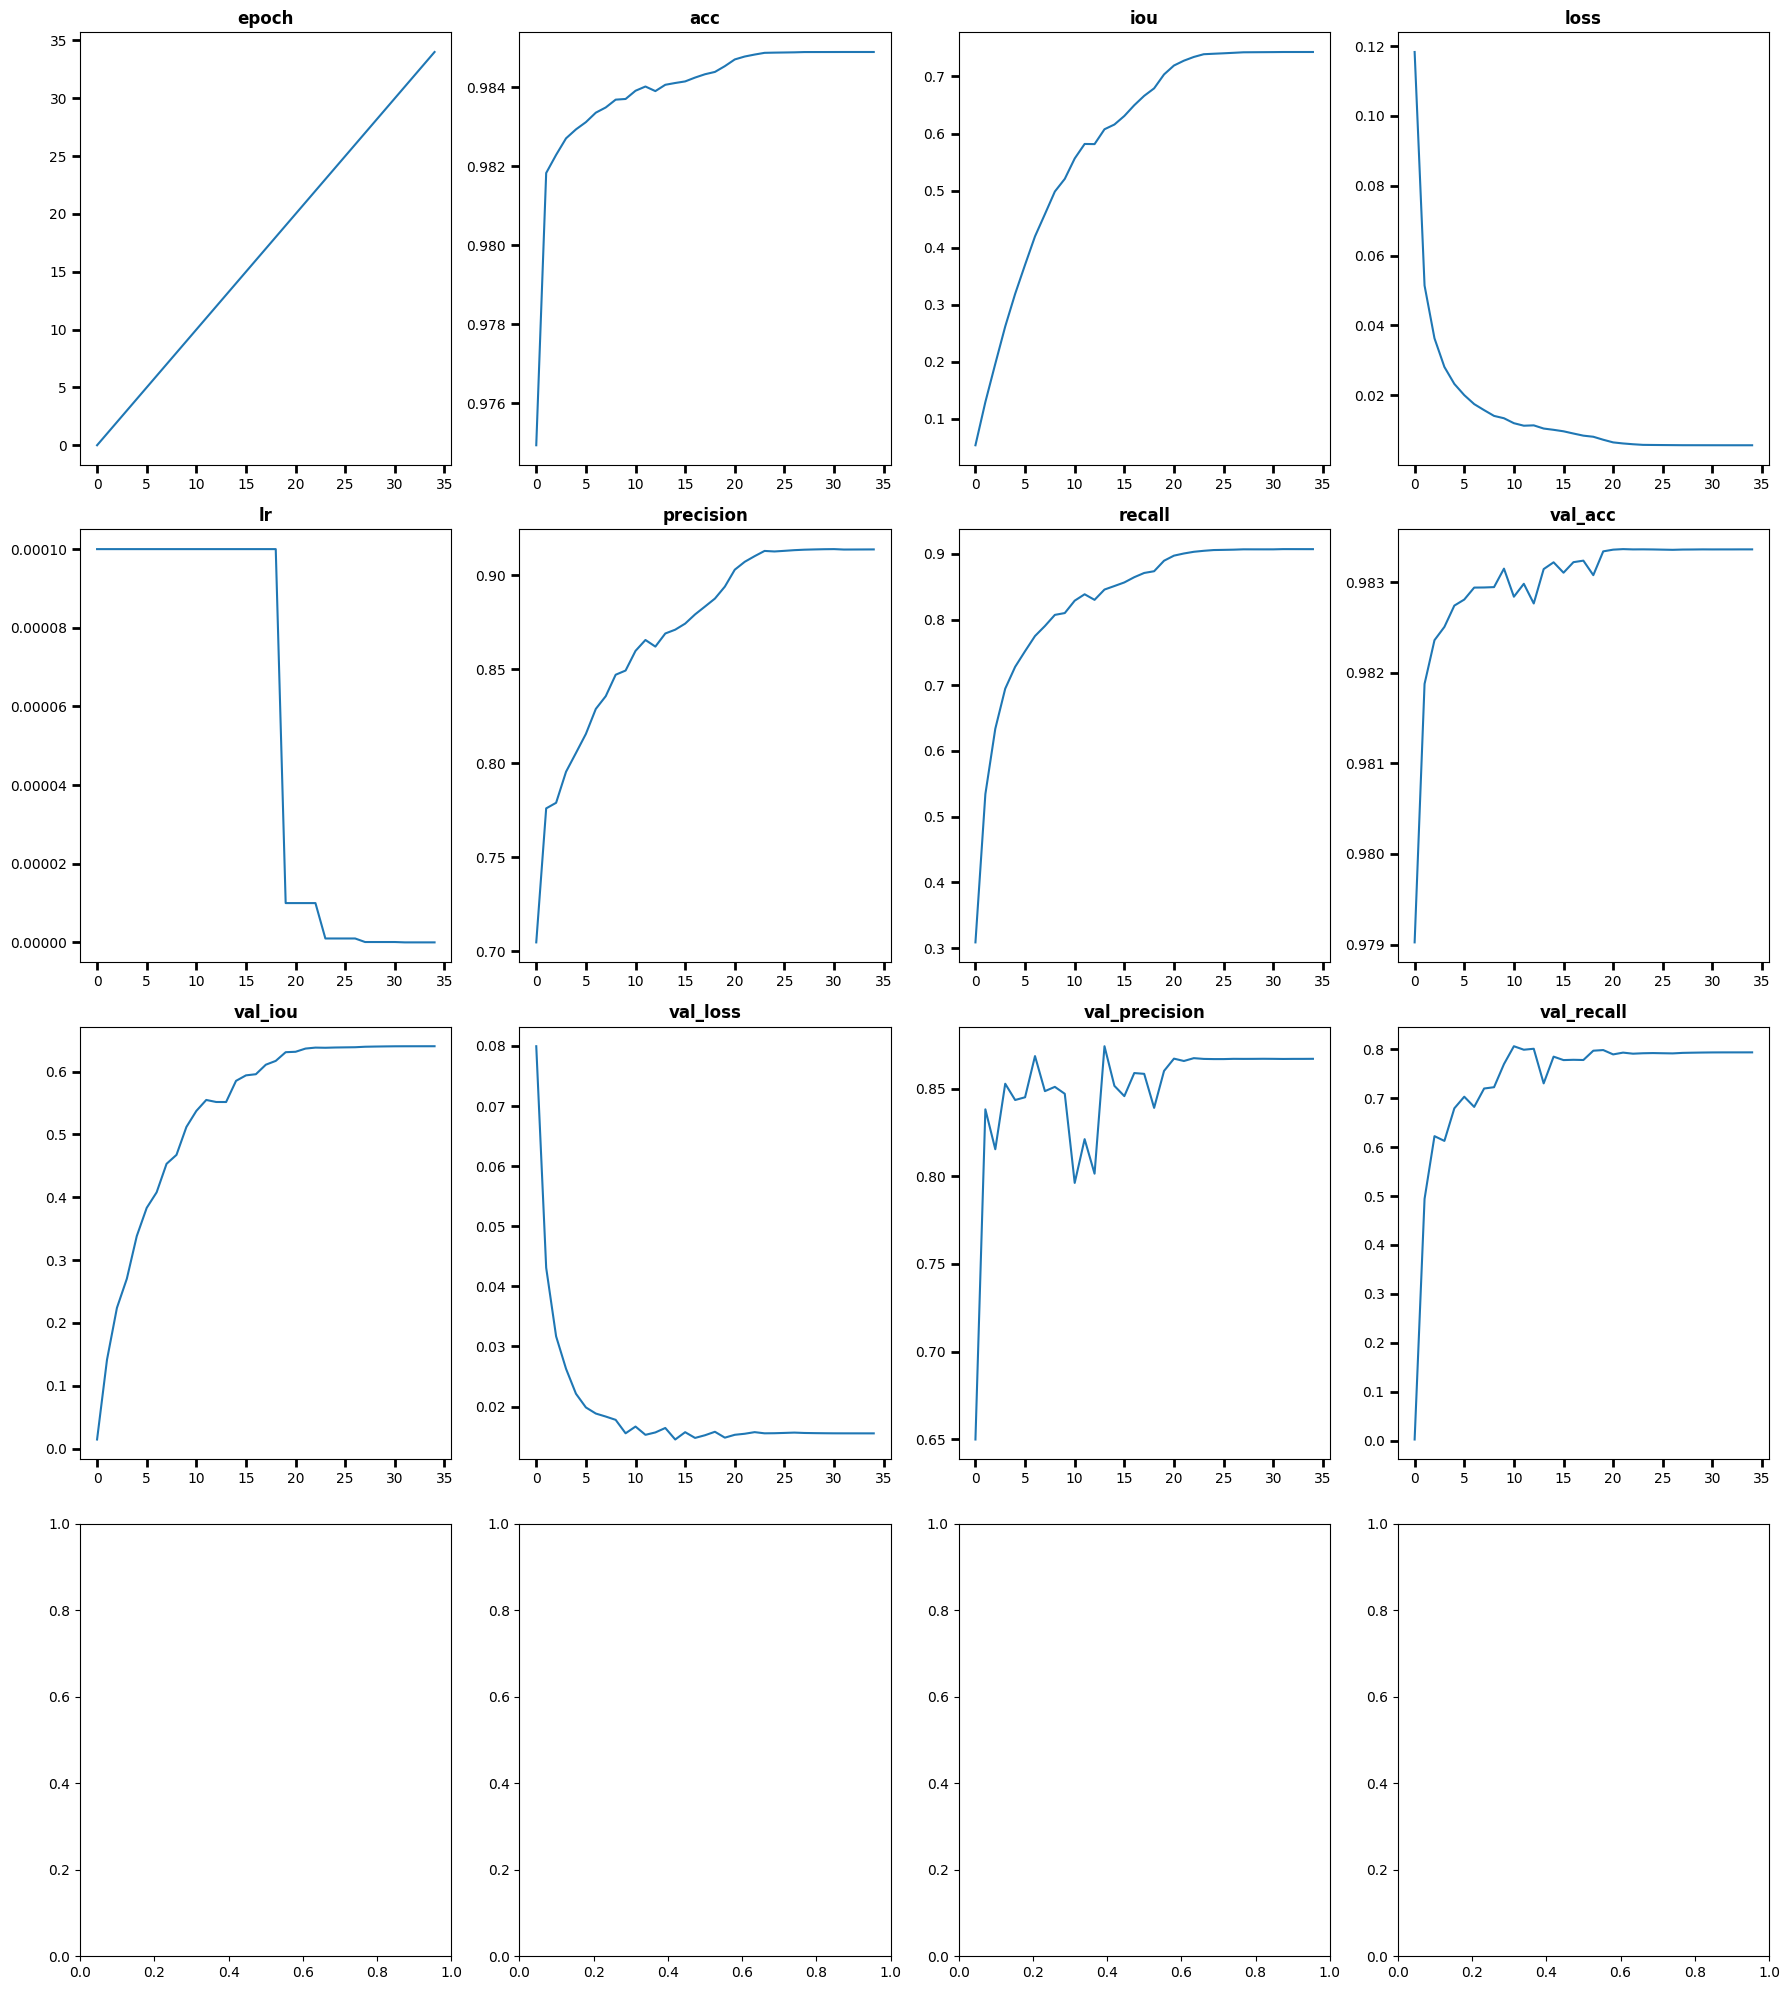

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv("/Users/kesavreddy/Downloads/College/Sem VII/Computer_Vision/Files/log-non-aug.csv")

# Get the column names
columns = data.columns

# Calculate the number of rows and columns for subplots
num_rows = 4
num_cols = 4

# Create a figure with appropriate number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 20))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Iterate over the column names and plot the data
for i, column in enumerate(columns):
    axs[i].plot(data[column])
    axs[i].set_title(column, fontweight='bold')
    axs[i].tick_params(axis='both', which='major', labelsize=10, width=2, length=6)

# Adjust subplot spacing and display the plot
plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 1s/step


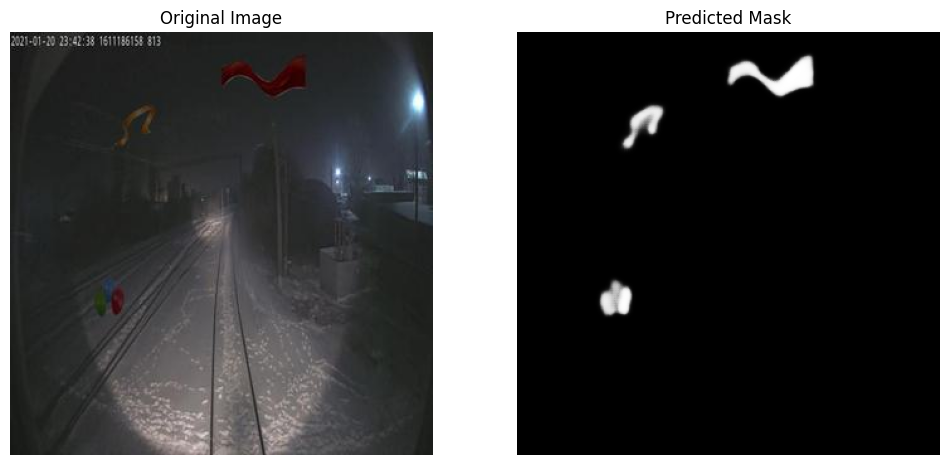

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define custom functions used during training
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7))
    return iou

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# Function to read and preprocess a single image
def read_single_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (336, 336))
    x = x / 255.0
    return x

# Function to predict mask for an image
def predict_mask(model, image_path):
    img = read_single_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    mask = model.predict(img)
    return mask.squeeze()  # Squeeze the mask to remove extra dimensions

if __name__ == "__main__":
    # Load the trained Keras model
    model_path = "/Users/kesavreddy/Downloads/College/Sem VII/Computer_Vision/Files/unet-non-aug.keras"
    model = tf.keras.models.load_model(model_path, custom_objects={'iou': iou, 'precision': precision, 'recall': recall})

    # Path to the test image
    test_image_path = "/Users/kesavreddy/Downloads/College/Sem VII/Computer_Vision/Dataset/valid/images/15_aug_3_jpg.rf.ad251c3da06ef9a93243dd39d8dae72b.jpg"

    # Generate prediction mask
    predicted_mask = predict_mask(model, test_image_path)

    # Read original image
    original_image = cv2.imread(test_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display original image and predicted mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    plt.show()


1/1 [==============================] - 0s 398ms/step


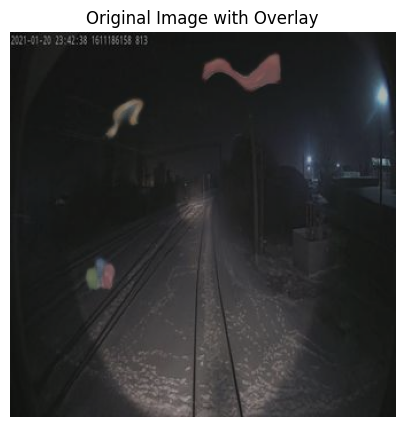

In [24]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Define custom functions used during training
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7))
    return iou

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# Function to read and preprocess a single image
def read_single_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (336, 336))
    x = x / 255.0
    return x

# Function to predict masks for a set of images
def predict_masks(model, image_paths):
    masks = []
    for path in image_paths:
        img = read_single_image(path)
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        mask = model.predict(img)
        masks.append(mask.squeeze())  # Squeeze the mask to remove extra dimensions
    return masks

if __name__ == "__main__":
    # Load the trained model
    model_path = "/Users/kesavreddy/Downloads/College/Sem VII/Computer_Vision/Files/unet-non-aug.keras"
    model = tf.keras.models.load_model(model_path, custom_objects={'iou': iou, 'precision': precision, 'recall': recall})

    # Paths to test images
    test_image_paths = ["/Users/kesavreddy/Downloads/College/Sem VII/Computer_Vision/Dataset/valid/images/15_aug_3_jpg.rf.ad251c3da06ef9a93243dd39d8dae72b.jpg"]

    # Generate predictions
    predicted_masks = predict_masks(model, test_image_paths)

    # Display original images with overlaid masks
    for i, (image_path, mask) in enumerate(zip(test_image_paths, predicted_masks)):
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Resize mask to match the shape of the original image
        mask_resized = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]))

        # Convert mask to 3 channels
        mask_rgb = np.zeros_like(original_image)
        mask_rgb[:, :, 0] = mask_resized * 255  # Red channel
        mask_rgb[:, :, 1] = mask_resized * 255  # Green channel
        mask_rgb[:, :, 2] = mask_resized * 255  # Blue channel

        # Overlay mask on the original image
        overlaid_image = cv2.addWeighted(original_image, 0.7, mask_rgb, 0.3, 0)

        plt.figure(figsize=(10, 5))
        plt.imshow(overlaid_image)
        plt.title('Original Image with Overlay')
        plt.axis('off')
        plt.show()
